## Importing Modules

In [1]:
# import mlflow

In [2]:
# mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.set_experiment('/HBV')

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob as gb
import pandas as pd

import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.layers import Layer
from tensorflow.keras.layers import Activation, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, UpSampling2D, Concatenate
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.models import load_model
import cv2
import albumentations as A
from tqdm import tqdm
from tqdm.contrib.concurrent import thread_map
from tqdm.asyncio import tqdm as async_tqdm
import skimage as ski

from skimage import io
import pickle

AUTOTUNE = tf.data.experimental.AUTOTUNE

from tensorflow.keras.applications.efficientnet import EfficientNetB4

2024-03-05 19:58:05.624916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 19:58:05.625023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 19:58:05.773243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Check if a GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Check TensorFlow version and GPU availability
print("TensorFlow Version: ", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
TensorFlow Version:  2.15.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data preprocess

In [5]:
base_path = '/kaggle/input/blood-vessel-segmentation/'
models = [
    '/kaggle/input/blood-vessel-segmentation-512x512-1/model_checkpoint.ckpt'
]
    
def plot_image_path(path, idx=0):
    all_path = gb.glob(path)
    image = get_image(all_path[idx])
    print(image.shape)
    tmp = plt.imshow(image, cmap='gray')
    plt.colorbar(tmp)
    
def plot_image(image):
    tmp = plt.imshow(image, cmap='gray')
    plt.colorbar(tmp)

def get_image(path):
    return np.array(Image.open(path)) 

In [6]:
SIZE = 512
INPUT_SHAPE = (512, 512)
SIZE_F = 256.0
TH = 0.999

In [7]:
def percentile_normalize(image, percentile=0.04):
    lower_limit = np.percentile(image, percentile)
    upper_limit = np.percentile(image, 100. - percentile)
    if upper_limit - lower_limit ==0:
        return image
    normalized_image = np.clip(image, lower_limit, upper_limit)
    normalized_image = (normalized_image - lower_limit) / (upper_limit - lower_limit)
    return normalized_image

In [8]:
def preprocess_image(source, is_image=False):
    if is_image:
        image = percentile_normalize(source)
    else:
        image = percentile_normalize(get_image(source))
    
    if image.ndim > 2 and image.shape[2] > 1:
        image = image[...,0]
    image = (image / 255.).astype(np.float32)
    image = ski.transform.resize(image, INPUT_SHAPE, order=0) 
    return image
    

def preprocess_label(source, is_image=False):
    if is_image:
        label = source
    else:
        label = get_image(source)
    
    if label.ndim > 2 and label.shape[2] > 1:
        label = label[..., 0]
        
    label = (label / 255.).astype(np.float32)
    label = ski.transform.resize(label, INPUT_SHAPE, order=0) 
    return label

In [9]:
def get_feature(image):

    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(image).numpy()]))

def to_tfrecord(input_zipped):
    split_image, split_label, idx, is_train = input_zipped
    images = np.array([preprocess_image(i) for i in split_image])
    labels = np.array([preprocess_label(i) for i in split_label])

    tag = 'train' if is_train else 'val'
    for i in range(len(images)):
        features = {
            'image': get_feature(images[i]),
            'label': get_feature(labels[i])
        }

        with tf.io.TFRecordWriter(f'{tag}/tf_{(idx*len(images) + i) + 1:05d}.tfrecord') as writer:
            example = tf.train.Example(features=tf.train.Features(feature=features))
            writer.write(example.SerializeToString())
        
def load_dataset(filenames, ordered=False):
    """
    Creating a dataset
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order

    return dataset

def processing_data(files_exist=False):
    chunk_size = 200
    # Kidney 1 dense for learning and Kidney 2 for validation process
    image_files = gb.glob(base_path+'train/kidney_1_dense/images/*')
    label_files = gb.glob(base_path+'train/kidney_1_dense/labels/*')

    image_files += gb.glob(base_path+'train/kidney_1_voi/images/*')
    label_files += gb.glob(base_path+'train/kidney_1_voi/labels/*')

    image_files += gb.glob(base_path+'train/kidney_2/images/*')
    label_files += gb.glob(base_path+'train/kidney_2/labels/*')

    image_files += gb.glob(base_path+'train/kidney_3_sparse/images/*')
    label_files += gb.glob(base_path+'train/kidney_3_sparse/labels/*')
        
    image_subset = np.array_split(image_files, chunk_size)
    label_subset = np.array_split(label_files, chunk_size)
    if not files_exist:

        try:
            os.mkdir('train')
        except FileExistsError: 
            pass

        try:
            os.mkdir('val')
        except FileExistsError: 
            pass

        _ = thread_map(to_tfrecord,
                    [(image_subset[i], label_subset[i], i ,i < int(chunk_size * 0.9)-1) for i in range(chunk_size)], 
                    tqdm_class=async_tqdm, total=chunk_size, ncols=100)
    train_path = sorted(tf.io.gfile.glob('/kaggle/working/train/*'))
    train_count = int(len(image_files) * 0.9)
    train_dataset = load_dataset(train_path)
    
    val_path = sorted(tf.io.gfile.glob('/kaggle/working/val/*'))
    val_count = int(len(image_files) - train_count)
    val_dataset = load_dataset(val_path)
    
    return train_dataset, val_dataset, train_count, val_count
    
train_ds, val_ds, train_count, val_count = processing_data(files_exist=False)

100%|█████████████████████████████████████████████████████████████| 200/200 [09:31<00:00,  2.86s/it]


In [10]:
def read_labeled_tfrecord(example):

    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "label": tf.io.FixedLenFeature([], tf.string),
    }
    
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = tf.io.parse_tensor(example['image'], tf.float32)
    image = tf.reshape(image, [*INPUT_SHAPE, 1])
    
    #getting label
    label = tf.io.parse_tensor(example['label'], tf.float32)
    label = tf.reshape(label, [*INPUT_SHAPE, 1])
    
    return image, label

In [11]:
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, border_mode=1, p=0.5),
        A.GridDistortion(num_steps=5, distort_limit=0.1, border_mode=1, p=0.5)
    ], p=0.4),
    A.GaussNoise(var_limit=0.05, p=0.1),
])

In [12]:
def aug(image, label):
    aug_data = transforms(image=image, mask=label)
    aug_image = aug_data['image']
    aug_label = aug_data['mask']
    return aug_image, aug_label

def aug_process(images, labels):
    aug_images, aug_labels = tf.numpy_function(func=aug, inp=[images, labels], Tout=(tf.float32, tf.float32))
    return aug_images, aug_labels

In [13]:
def set_shapes(img, label, img_shape=(SIZE,SIZE,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label

In [14]:
# .map(aug_process, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.repeat().map(read_labeled_tfrecord, num_parallel_calls=AUTOTUNE).map(aug_process, num_parallel_calls=AUTOTUNE).map(set_shapes, num_parallel_calls=AUTOTUNE).batch(8).prefetch(AUTOTUNE)

val_ds = val_ds.cache().map(read_labeled_tfrecord, num_parallel_calls=AUTOTUNE).map(set_shapes, num_parallel_calls=AUTOTUNE).batch(8).prefetch(AUTOTUNE)

# Custom Classes

In [15]:
class SentimentSegmentation():

    def __init__(self, train_ds, val_ds, input_shape=(INPUT_SHAPE[0],INPUT_SHAPE[1],1), encoders=None, decoders=None):
        self.seed = 2024
        self.encoders = encoders
        self.decoders = decoders
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.input_shape = input_shape
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1)
        self.generate()
        self.gpus = tf.config.experimental.list_physical_devices('GPU')
        self.checkpoint_path = "/kaggle/working/model_checkpoint.ckpt"
        self.model_checkpoint = ModelCheckpoint(self.checkpoint_path, monitor='val_loss', verbose=1, save_best_only=False)
    
    def check_cp(self):
        if os.path.exists(self.checkpoint_path):
            self.model =  load_model(self.checkpoint_path, custom_objects={
                                                        'bce_dice_loss': self.bce_dice_loss, 
                                                        'dice_coef': self.dice_coef, 
                                                        'iou_coef': self.iou_coef})
        else:
            print('No Checkpoint Available!')
    
    def load_model(self, path):
        if os.path.exists(path):
            self.model =  load_model(path, custom_objects={
                                                        'bce_dice_loss': self.bce_dice_loss, 
                                                        'dice_coef': self.dice_coef, 
                                                        'iou_coef': self.iou_coef})
        else:
            print('No Checkpoint Available!')
    
    def feed_new_data(self, x, y, val_x, val_y):
        self.x_train = x
        self.y_train = y
        self.x_test = val_x
        self.y_test = val_y
        self.check_cp()
        self.fit_gpu()
        
    def seed_everything(seed=2024):
        import random
        random.seed(seed)
        np.random.seed(seed)

    def create_encoder(self, x, conv_num=2, filters_num=64, kernel_size=3, stride=1, padding='same', pool_size=(2, 2), normalize=False):
        for _ in range(conv_num):
            x = Conv2D(filters=filters_num, kernel_size=(kernel_size, kernel_size), strides=stride, padding=padding)(x)
            x = Activation('relu')(x)
            
        p = tf.keras.layers.AveragePooling2D(pool_size)(x)
        
        if normalize:
                p = BatchNormalization()(p)
        return p, x
    
    def create_bottleneck(self, x, conv_num=2, filters_num=64, kernel_size=3, stride=1, padding='same', pool_size=(2, 2)):
        for _ in range(conv_num):
            x = Conv2D(filters=filters_num, kernel_size=(kernel_size, kernel_size), strides=stride, padding=padding)(x)
            x = Activation('relu')(x)

        return x

    def create_decoder(self,x, extra=None, conv_num=2, filters_num=64, kernel_size=3, stride=1, padding='same', pool_size=(2, 2), normalize=False, is_output=False):
        
        x = tf.keras.layers.Conv2DTranspose(filters_num, kernel_size, strides = (2,2), padding = 'same')(x)
#         x = UpSampling2D(pool_size)(x)
        if extra is not None:
            x = Concatenate()([x, extra])
            
        print('decoder:')
        if normalize:
            x = BatchNormalization()(x)
            
        for i in range(conv_num):
            x = Conv2D(filters=filters_num, kernel_size=(kernel_size, kernel_size), strides=stride, padding=padding)(x)
            x = Activation('relu')(x)
            print(x.shape)
            
        if is_output:
            x = Conv2D(1, (1, 1), 1)(x)
            print('last_layer:', x.shape)
            x = Reshape((self.input_shape[0]*self.input_shape[1], 1), input_shape=self.input_shape,)(x)
            x = Activation('sigmoid')(x)
            x = Reshape((self.input_shape[0], self.input_shape[1], 1), input_shape=x.shape,)(x)
            
        return x

    def generate(self):
        inputs = Input(shape=self.input_shape)
        base_filter_number=64
#         backbone = EfficientNetB4(input_shape = self.input_shape, include_top = False, input_tensor=inputs,
#                            weights='/kaggle/input/tensorflow-keras-efficientnet-imagenet-weights/efficientnetb4_notop.h5',
#                            drop_connect_rate=0.4)
#         inputss = backbone.input

        

        # Encoders    
        print('Inputs:',inputs.shape)
        c1, x1 = self.create_encoder(inputs, filters_num=base_filter_number * 1, normalize=True)
        print(c1.shape)
        c2, x2 = self.create_encoder(c1, filters_num=base_filter_number * 2, normalize=True)
        print(c2.shape)
        c3, x3 = self.create_encoder(c2, conv_num=3, filters_num=base_filter_number * 4)
        print(c3.shape)
        c4, x4 = self.create_encoder(c3, conv_num=3, filters_num=base_filter_number * 8)
        print('ta-da',c4.shape,'\n\n')
        
        bn = self.create_bottleneck(c4, filters_num=base_filter_number * 16)
        
        # Decoders
        dec5 = self.create_decoder(bn, x4, conv_num=3, filters_num=base_filter_number * 8)
        print('after:',dec5.shape)
        dec4 = self.create_decoder(dec5, x3, conv_num=3, filters_num=base_filter_number * 4)
        print('after:',dec4.shape)
        dec3 = self.create_decoder(dec4, x2, conv_num=3, filters_num=base_filter_number * 2, normalize=True)
        print('after:',dec3.shape)
        dec2 = self.create_decoder(dec3, x1, filters_num=base_filter_number * 1, normalize=True, is_output=True)
        print('after:',dec2.shape)

        self.model = Model(inputs=inputs, outputs=dec2, name="UNet")
        return self.model

    def lr_scheduler(self, epoch, lr):
        decay_rate = 0.1
        decay_step = 2
        
        if epoch % decay_step == 0 and epoch:
            return lr * decay_rate
        return lr

    def dice_coef(self,y_true, y_pred, smooth=1e-6):
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(self,y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou

    def dice_loss(self, y_true, y_pred):
        return 1. - self.dice_coef(y_true, y_pred)
    
    def focal_tversky_loss(self, y_true, y_pred, alpha=0.7, beta=0.3, gamma=4/3, smooth=1e-6):
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        
        tp = K.sum(y_true_f * y_pred_f)
        fp = K.sum((1 - y_true_f) * y_pred_f)
        fn = K.sum(y_true_f * (1 - y_pred_f))

        tversky = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)
        focal_tversky = K.pow((1 - tversky), gamma)

        return focal_tversky
    
    def bce(self, y_true, y_pred):
        return binary_crossentropy(y_true, y_pred)

    def weighted_loss(self,y_true, y_pred):
        return self.dice_loss(y_true, y_pred) + self.focal_tversky_loss(y_true, y_pred)

    def summary(self):
        return self.model.summary()

    def compile(self):
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.model.compile(optimizer=optimizer, loss=self.focal_tversky_loss, metrics=[self.dice_coef,self.iou_coef])

    def fit(self):
        scheduler = LearningRateScheduler(self.lr_scheduler, verbose=1)
#         mlflow.tensorflow.autolog()
        self.model.fit(self.train_ds,
                       steps_per_epoch= train_count // 8,
                       epochs=60,
                       validation_data=self.val_ds,
                       validation_steps=val_count // 8,
                       callbacks=[self.early_stopping, scheduler, self.model_checkpoint])

    def fit_gpu(self):
        if self.gpus:
            with tf.device('/GPU:0'):
                results = self.fit()
                print("GPU is available and used.")
        else:
            print("No GPU available.")
            self.fit()
            
    def get_model(self):
        return self.model

In [16]:
SS = SentimentSegmentation(train_ds, val_ds)
SS.compile()
# SS.summary()

Inputs: (None, 512, 512, 1)
(None, 256, 256, 64)
(None, 128, 128, 128)
(None, 64, 64, 256)
ta-da (None, 32, 32, 512) 


decoder:
(None, 64, 64, 512)
(None, 64, 64, 512)
(None, 64, 64, 512)
after: (None, 64, 64, 512)
decoder:
(None, 128, 128, 256)
(None, 128, 128, 256)
(None, 128, 128, 256)
after: (None, 128, 128, 256)
decoder:
(None, 256, 256, 128)
(None, 256, 256, 128)
(None, 256, 256, 128)
after: (None, 256, 256, 128)
decoder:
(None, 512, 512, 64)
(None, 512, 512, 64)
last_layer: (None, 512, 512, 1)
after: (None, 512, 512, 1)


In [17]:
# SS.check_cp()

SS.fit_gpu()
model = SS.get_model()


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/60


I0000 00:00:1709669298.835083      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


779/779 [==============================] - ETA: 0s - loss: 0.9872 - dice_coef: 0.0133 - iou_coef: 0.0097
Epoch 1: saving model to /kaggle/working/model_checkpoint.ckpt
779/779 [==============================] - 863s 1s/step - loss: 0.9872 - dice_coef: 0.0133 - iou_coef: 0.0097 - val_loss: 0.9947 - val_dice_coef: 0.0056 - val_iou_coef: 0.0028 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/60
779/779 [==============================] - ETA: 0s - loss: 0.9861 - dice_coef: 0.0145 - iou_coef: 0.0115
Epoch 2: saving model to /kaggle/working/model_checkpoint.ckpt
779/779 [==============================] - 811s 1s/step - loss: 0.9861 - dice_coef: 0.0145 - iou_coef: 0.0115 - val_loss: 1.0000 - val_dice_coef: 1.8370e-10 - val_iou_coef: 0.1397 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.00010000000474974513.
Epoch 3/60
779/779 [==============================] - ETA: 0s - loss: 0.9868 - dice_coef: 0.0135 - iou_coef: 0

1/1 [==============================] - 0s 24ms/step
1.1027401e-05
0.0
0.33333334


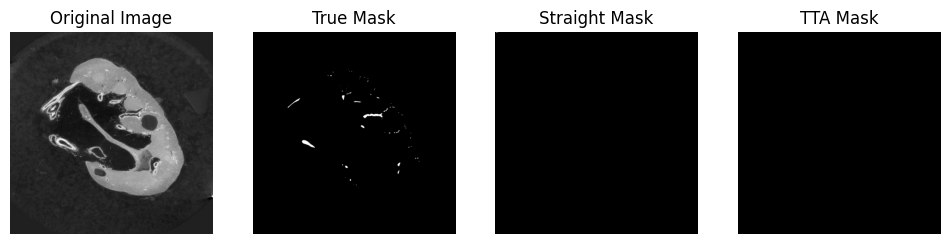

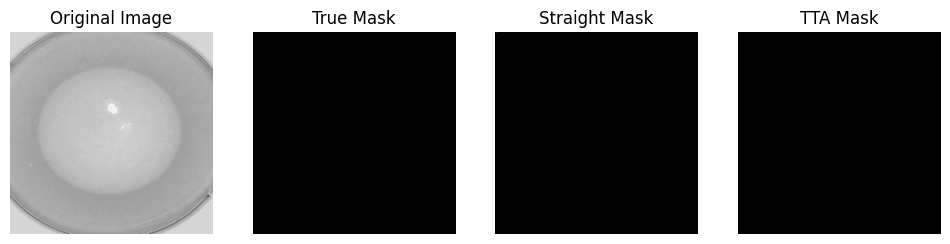

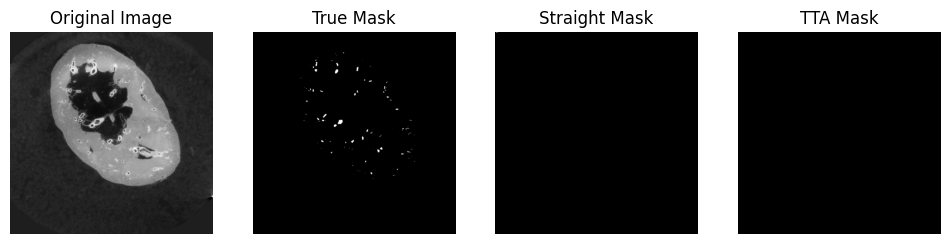

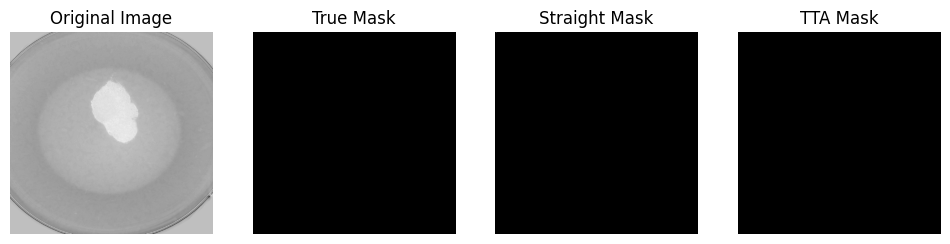

1/1 [==============================] - 0s 26ms/step
7.4022164e-06
0.0
0.33333334


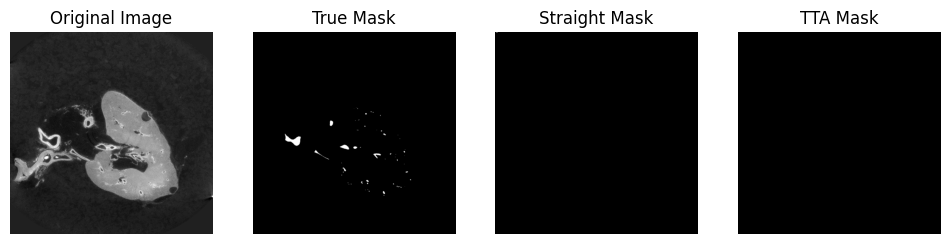

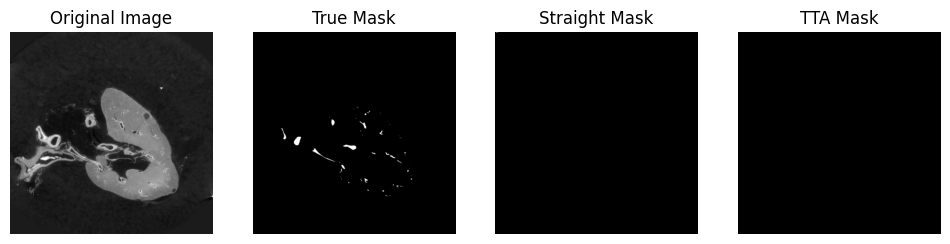

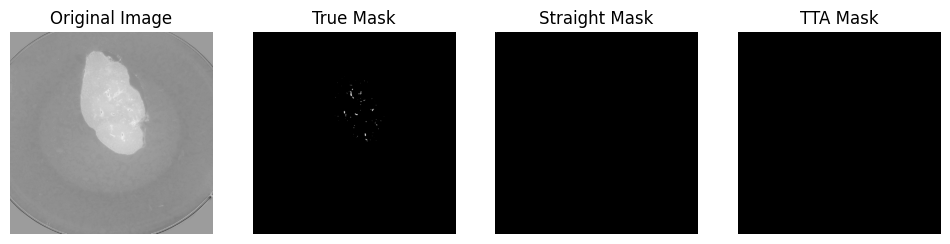

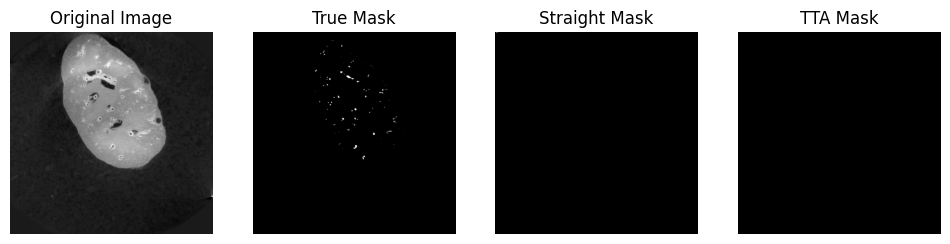

1/1 [==============================] - 0s 24ms/step
1.2072885e-05
0.0
0.33333334


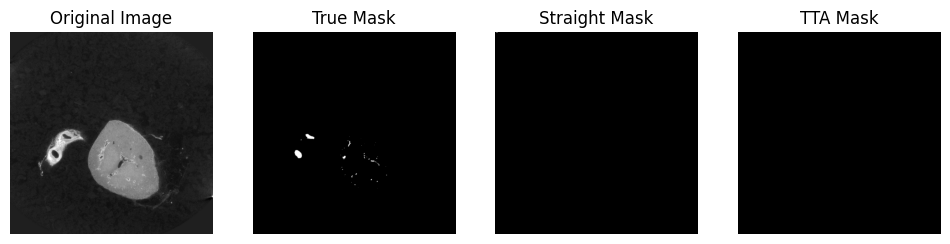

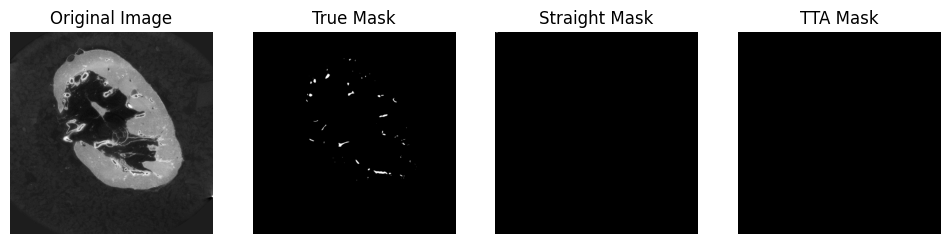

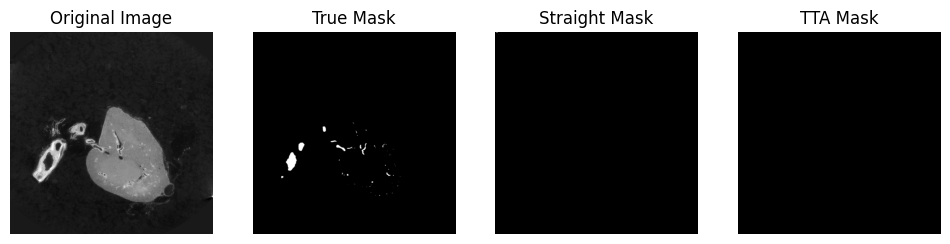

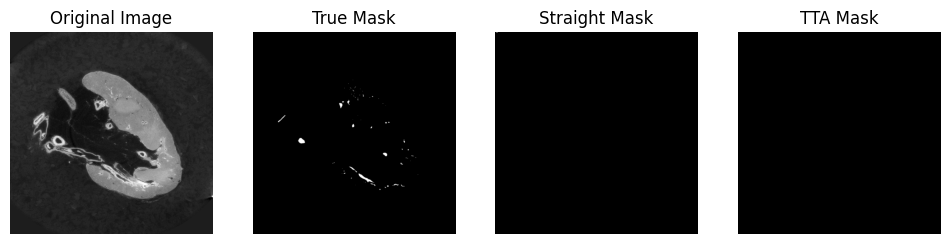

1/1 [==============================] - 0s 29ms/step
1.3328891e-05
0.0
0.33333334


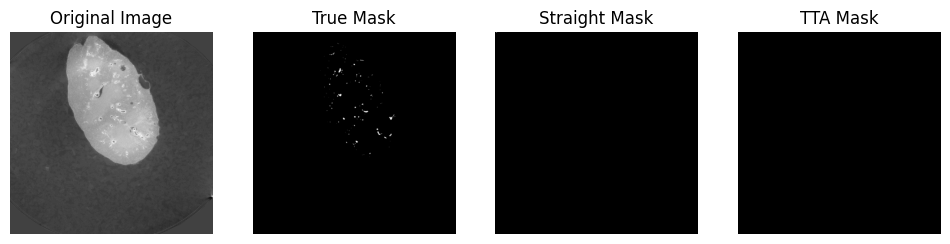

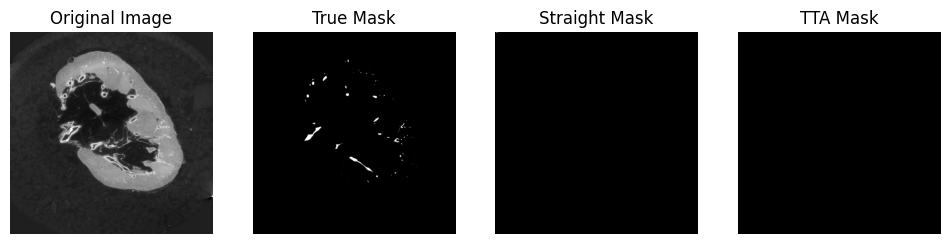

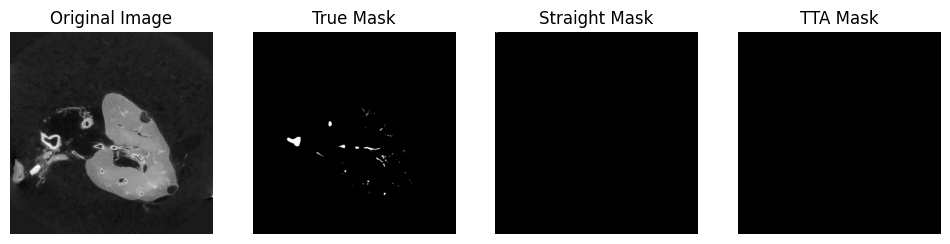

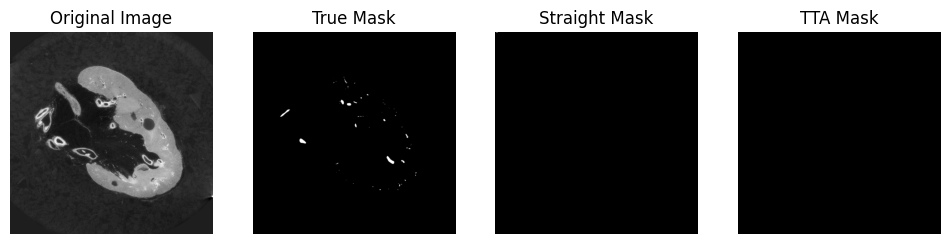

1/1 [==============================] - 0s 24ms/step
1.1625141e-05
0.0
0.33333334


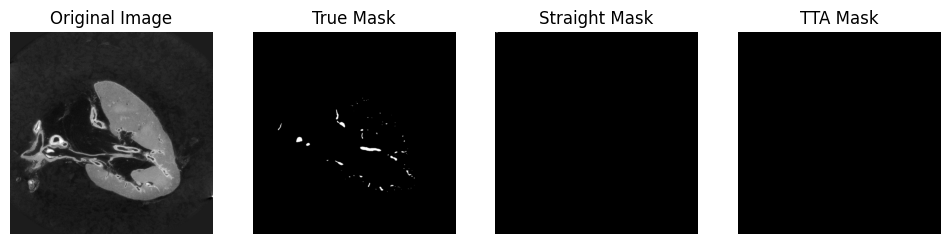

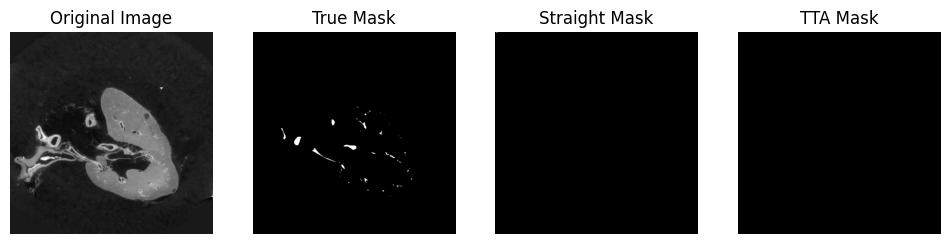

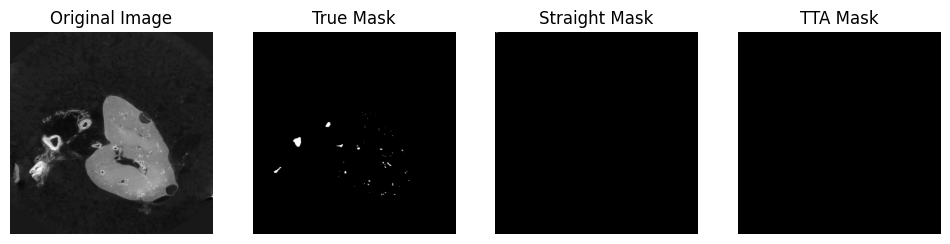

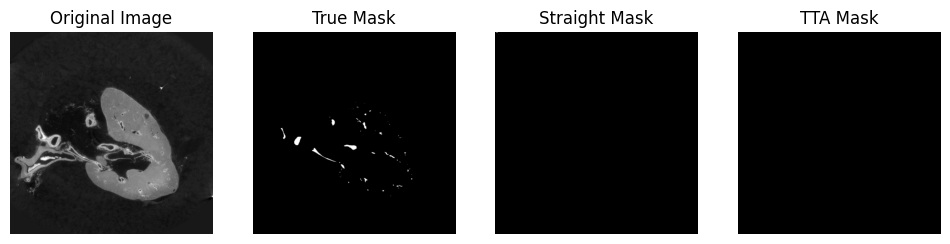

In [18]:
import random

for image, label in val_ds.take(5):
    sample_images = image.numpy()
    sample_true_masks = label

    # TTA
    h_flip = A.Compose([A.HorizontalFlip(p=1.0)])
    h_flip_test = np.array([h_flip(image=x)['image'] for x in sample_images])
    v_flip = A.Compose([A.VerticalFlip(p=1.0)])
    v_flip_test = np.array([v_flip(image=x)['image'] for x in sample_images])
    
    org_labels = model.predict(sample_images)
    h_flip_labels = [h_flip(image=x)['image'] for x in model.predict(h_flip_test)]
    v_flip_labels = [v_flip(image=x)['image'] for x in model.predict(v_flip_test)]

    # with TTA
    sample_pred_masks = (org_labels + h_flip_labels + v_flip_labels)/3
    
    print(np.mean(sample_pred_masks))
    print(np.min(sample_pred_masks))
    print(np.max(sample_pred_masks))
    
    # Thresholding example (adjust threshold as needed)
    sample_pred_masks = (sample_pred_masks > 0.5).astype(np.float16)

    for i in range(4):
        plt.figure(figsize=(12, 5))

        # Display original image
        plt.subplot(1, 4, 1)
        plt.imshow(sample_images[i], cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Display true mask
        plt.subplot(1, 4, 2)
        plt.imshow(sample_true_masks[i], cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Display predicted mask
        plt.subplot(1, 4, 3)
        plt.imshow(org_labels[i], cmap='gray')
        plt.title('Straight Mask')
        plt.axis('off')
        
        # Display predicted mask
        plt.subplot(1, 4, 4)
        plt.imshow(sample_pred_masks[i], cmap='gray')
        plt.title('TTA Mask')
        plt.axis('off')
        plt.savefig(f'result_{i + 1:02d}.png')
        plt.show()

In [19]:
# test_set_path = '/kaggle/input/blood-vessel-segmentation/test'
# test_images_path = []

# for dirs in gb.glob(test_set_path + '/*'):
#     test_images_path += gb.glob(dirs+'/images/*')
        
# test_images = np.array([preprocess_image(i) for i in sorted(test_images_path)])

In [20]:
# TTA
# h_flip = A.Compose([A.HorizontalFlip(p=1.0)])
# h_flip_test = np.array([h_flip(image=x)['image'] for x in test_images])
# v_flip = A.Compose([A.VerticalFlip(p=1.0)])
# v_flip_test = np.array([v_flip(image=x)['image'] for x in test_images])

In [21]:
# make predictions
# org_labels = model.predict(test_images)
# h_flip_labels = [h_flip(image=x)['image'] for x in model.predict(h_flip_test)]
# v_flip_labels = [h_flip(image=x)['image'] for x in model.predict(v_flip_test)]

# # with TTA
# predicted_labels = (org_labels + h_flip_labels + v_flip_labels)/3

# without TTA
# predicted_labels = model.predict(tf.data.Dataset.from_tensor_slices(test_images))

In [22]:
# predicted_labels = tf.image.resize(predicted_labels, [1303, 912], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

In [23]:
# int_labels = (predicted_labels > 0.02)

In [24]:
# plot_image(int_labels[4])

# print(int_labels[4].shape)
# print(np.mean(int_labels[4]))
# print(np.max(int_labels[4]))

In [25]:
# plot_image(test_images[4])
# np.mean(test_images[4])
# np.max(test_images[4])

In [26]:
# def rle_encode(img):
#     '''
#     img: numpy array, 1 - mask, 0 - background
#     Returns run length as string formated
#     '''
#     img = np.array(img)
#     pixels = img.flatten()
#     pixels = np.concatenate([[0], pixels, [0]])
#     runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
#     runs[1::2] -= runs[::2]
#     rle = ' '.join(str(x) for x in runs)
#     if rle=='':
#         rle = '1 0'
#     return rle

In [27]:
# all_rle = [rle_encode(label) for label in int_labels]
# ids = [f'{p.split("/")[-3]}_{os.path.basename(p).split(".")[0]}' for p in test_images_path]

In [28]:
# submission = pd.DataFrame({
#     "id": ids,
#     "rle": all_rle
# })

In [29]:
# submission.head()

In [30]:
# submission.to_csv("submission.csv", index=False)